##### Quantum Data Science (LCD) 2025/2026
## Lecture 5 - Encoding classical data into quantum circuits

## Contents

1. [Basis Encoding](#basis_encoding)
2. [Amplitude Encoding](#amplitude_encoding)
3. [Angle Encoding](#angle_encoding)
5. [IQP Encoding](#iqp_encoding)    

## 1. Basis Encoding <a id="basis_encoding"></a>

Basis encoding associates a classical $n$-bit string with a computational basis state of a $n$-qubit system. For instance if we have the binary string $b = (b_1 b_2 \dots b_n)$ where $b_i \in \{0,1\}$ the mapping to a quantum state is:

$$
b = (b_1 b_2 \dots b_n) \mapsto |b\rangle = | b_1 b_2 \dots b_n \rangle 
$$ 


#### Example - Encode the datapoint x=(2,3) into a quantum state

Manual Encoding Sample: [1 0 1 1]


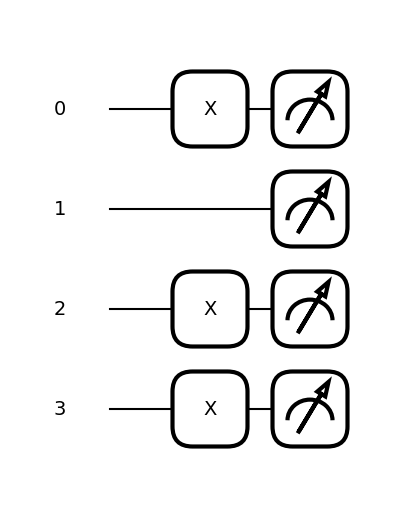

In [34]:
import pennylane as qml 
import numpy as np

#need at most 2 qubits for first feature and 2 qubit for second feature
n_qubit_1 = [0,1]
n_qubit_2 = [2,3]

dev = qml.device('default.qubit', wires=4, shots=1)

@qml.compile
@qml.qnode(dev)
def circuit(x, manually=True):
    #manually encoding the input
    if manually:    
    
        x_0_bin = np.binary_repr(x[0], width=len(n_qubit_1))
        for i in range(len(x_0_bin)):
            if x_0_bin[i] == '1':
                qml.PauliX(n_qubit_1[i])
        
        x_1_bin = np.binary_repr(x[1], width=len(n_qubit_2))
        for i in range(len(x_1_bin)):
            if x_1_bin[i] == '1':
                qml.PauliX(n_qubit_2[i])
    
    else:
        #using amplitude encoding
        qml.BasisEmbedding(list(map(int,np.binary_repr(x[0], width=len(n_qubit_1)))), wires=n_qubit_1)
        qml.BasisEmbedding(list(map(int,np.binary_repr(x[1], width=len(n_qubit_2)))), wires=n_qubit_2)

    return qml.sample()

#testing the circuit

x = [2, 3]

qml.draw_mpl(circuit, show_all_wires=True)(x, manually=False)

print("Manual Encoding Sample:", circuit(x, manually=False))


## 2. Amplitude Encoding <a id="amplitude_encoding"></a>

Amplitude encoding encodes data into the amplitudes of a quantum state. Suppose we have a datapoint with $N$ features $x=(x_0, x_1, \dots , x_{N-1})$. The amplitude encoded quantum state will be a  $\lceil log N \rceil$ qubit state in which each basis state will have an amplitude corresponding to the *normalized* feature $\hat{x_i}$ as:

$$ |x\rangle = \sum_{i=1}^{N} \hat{x_i} |i\rangle$$

such that the normalization is:  

$$ \hat{x_i} = \frac{x_i}{\sqrt{\sum_{i=1}^{N} |x_i|^2}}$$

i.e. $\sum_{i=1}^{N} |\hat{x_i}|^2 = 1$


#### <span style="color: red;">EXERCISE</span> - For simplicity, let's work the *example 4.1* of the book *Machine Learning with quantum computers*. The goal is instead of encoding a datapoint , encoding a probability distribution over the basis states. Encode the following quantum state: 

$$ |\psi\rangle = \sqrt{0.2}|000\rangle +  \sqrt{0.5}|010\rangle +  \sqrt{0.2}|110\rangle +  \sqrt{0.1}|111\rangle $$


Pennylane provides a function to encode the quantum state using the Mottonen algorithm. The function is called `pennylane.AmplitudeEmbedding`. The function receives the quantum state as a list of amplitudes and the wires where the state will be encoded. 


(<Figure size 400x400 with 1 Axes>, <Axes: >)
probs MottonenprobsPreparation: [2.00000000e-01 3.08148791e-33 3.08148791e-33 5.00000000e-01
 0.00000000e+00 2.00000000e-01 1.73333695e-33 1.00000000e-01]
probs AmplitudeEmbedding: [2.00000000e-01 3.08148791e-33 3.08148791e-33 5.00000000e-01
 0.00000000e+00 2.00000000e-01 1.73333695e-33 1.00000000e-01]


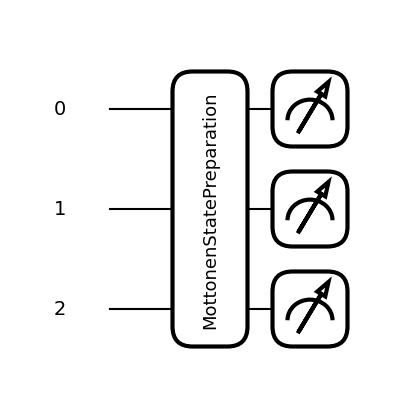

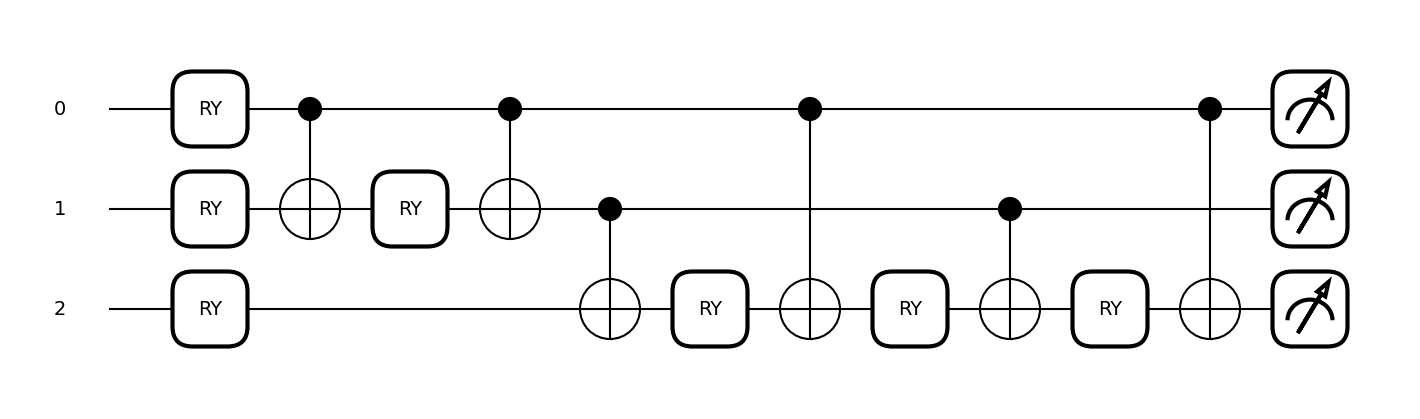

In [40]:
#### YOUR CODE HERE #### 

dev = qml.device('default.qubit', wires=3)

#@qml.compile
@qml.qnode(dev)
def circuit(state):
    qml.MottonenStatePreparation(state_vector=state, wires=range(3))
    return qml.probs()

@qml.compile
@qml.qnode(dev)
def circuit2(state):
    qml.AmplitudeEmbedding(state, wires=range(3))
    return qml.probs()


state = np.zeros(8)
state[0] = np.sqrt(0.2)
state[3] = np.sqrt(0.5)
state[5] = np.sqrt(0.2)
state[7] = np.sqrt(0.1)

print(qml.draw_mpl(circuit)(state))

qml.draw_mpl(circuit2)(state)

qc = circuit(state)
qc2 = circuit2(state)

print("probs MottonenprobsPreparation:", qc)
print("probs AmplitudeEmbedding:", qc2)



#### MottonenStatePreparation yields same circuit as AmplitudeEmbedding with the difference that the later can receive unormalized states as input ####


## 3. Angle Encoding <a id="angle_encoding"></a>

In *Angle Encoding* we encode each feature of a single datapoint in a single qubit, using simple *Pauli* rotation gates. For a point with $N$ features, $x = \{x_0, \dots, x_{N-1} \}$, angle encoding needs $N$ qubits and encode each feature as: 

$$ |x\rangle = \bigotimes_{i=0}^{N-1} e^{i x_i \sigma}|0\rangle$$

where $\sigma \in \{\sigma_x, \sigma_y, \sigma_z\}$ is the complete Pauli gate set.

For $\sigma = \sigma_y$ the encoding becomes:

$$ |x\rangle = \bigotimes_{i=0}^{N-1} cos(x_i)|0\rangle + sin(x_i) |1\rangle$$

Notice that this is a periodic encoding strategy. This means that we need to be sure that each feature is *normalized* in the range $[-\pi, \pi]$.

#### <span style="color: red;">EXERCISE</span> - Create the angle encoded quantum state for the *single* datapoint $x = (2,3,1,11,23)$, for $\sigma = \sigma_y$.

There are several normalization strategies, the simplest one to normalize each feature in the range $[-\pi , \pi]$ is:

$$\hat{x_i} = \frac{x_i}{max_{i} |x_i|} * \pi$$

$L_{\infty}$ normalizes each feature by the maximum absolute feature present in the datapoint i.e. for x = \{x_1, \dots, x_N \}$: 

$$|x|_{\infty} = max_{i} |x_i|$$

s.t the normalized feature $x_i$ becomes: 

$$ \hat{x_i} = \frac{x_i}{|x|_{\infty}}$$

This way each feature stays in the range $[-1,1]$.

array([2.24068910e-01, 5.43483360e-01, 6.02165011e-02, 1.46056257e-01,
       4.24105092e-04, 1.02867488e-03, 1.13974423e-04, 2.76447108e-04,
       3.85579489e-03, 9.35230308e-03, 1.03621014e-03, 2.51334720e-03,
       7.29803275e-06, 1.77015158e-05, 1.96128055e-06, 4.75712290e-06,
       1.70286043e-03, 4.13032001e-03, 4.57628399e-04, 1.10998629e-03,
       3.22307890e-06, 7.81763854e-06, 8.66173418e-07, 2.10091993e-06,
       2.93029520e-05, 7.10748616e-05, 7.87490436e-06, 1.91007287e-05,
       5.54629874e-08, 1.34526520e-07, 1.49051782e-08, 3.61527903e-08])

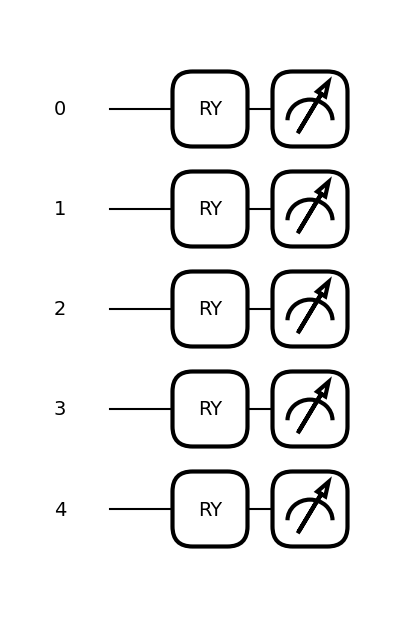

In [22]:
x = np.array([2,3,1,11,23])
n_qubits = len(x)

dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def angle_encoding(x, sigma="y"):
    
    max_abs_feature = np.max(np.abs(x))
    x_normalized = x/max_abs_feature

    for i in range(len(x_normalized)):
        angle = 2*x_normalized[i]
        if sigma == "y":
            qml.RY(angle, i)
        if sigma == "x":
            qml.RX(angle, i)
        if sigma == "z":
            qml.RZ(angle, i)

    return qml.probs(wires=range(n_qubits))

qml.draw_mpl(angle_encoding)(x, sigma="y")

angle_encoding(x, sigma="y")

array([7.22147981e-01, 2.15522473e-01, 4.29216798e-02, 1.28098213e-02,
       3.41387316e-04, 1.01885819e-04, 2.02907402e-05, 6.05569859e-06,
       3.08024832e-03, 9.19289055e-04, 1.83078034e-04, 5.46389819e-05,
       1.45615267e-06, 4.34583537e-07, 8.65480763e-08, 2.58299627e-08,
       1.36684128e-03, 4.07928873e-04, 8.12397531e-05, 2.42457127e-05,
       6.46158804e-07, 1.92843776e-07, 3.84051774e-08, 1.14618873e-08,
       5.83012162e-06, 1.73997887e-06, 3.46519855e-07, 1.03417607e-07,
       2.75612427e-09, 8.22555394e-10, 1.63813355e-10, 4.88895077e-11])

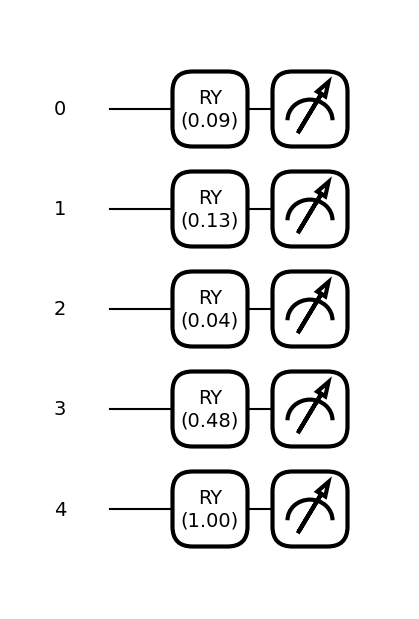

In [25]:
# or use AngleEmbedding directly

x = np.array([2,3,1,11,23])

dev = qml.device('default.qubit', wires=len(x))

@qml.compile
@qml.qnode(dev)
def angle_encoding(x, sigma="Y"):
    
    max_abs_feature = np.max(np.abs(x))
    x_normalized = x/max_abs_feature

    qml.AngleEmbedding(x_normalized, wires=range(len(x)), rotation=sigma)

    return qml.probs(wires=range(len(x)))


qml.draw_mpl(angle_encoding, decimals=2)(x, sigma="Y")

angle_encoding(x, sigma="Y")

### 5. IQP Encoding <a id="iqp_encoding"></a>

*IQP - Instantaneous Quantum Polynomial circuits* - Complex encoding strategy. Hadamard gates + Angle encoding (with $\sigma_z$ rotation) + controlled rotations for pairs of features. For $N$ features $x=\{x_0, \dots, x_{N-1}\}$ the encoding works on $N$ qubits as:

$$ |x\rangle = (U(x) H^{\otimes N})^r |0\rangle$$

where 

$$U(x) = \prod_{i,j \in x} e^{j (\pi - x_i)(\pi - x_j) \sigma_{z_i} \otimes \sigma_{z_j}} \bigotimes_{i=0}^{N-1} e^{j x_i \sigma_z}$$

where $r$ is the number of repetitions of the the encoding.
In essence , the circuit is as follows:

<p align="center">
  <img width="1000" height="200" src="images/iqp.png">
</p>

REMEMBER! The reason for iqp encoding is that this type of circuits are hard to simulate classically which may be a form of quantum advantage when used in quantum machine learning models.


#### <span style="color: red;">EXERCISE</span> Create the IQP encoded quantum state for the *single* datapoint $x = (2,3,1,11,23)$. Use $L_{\infty}$ normalization. 

array([0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125])

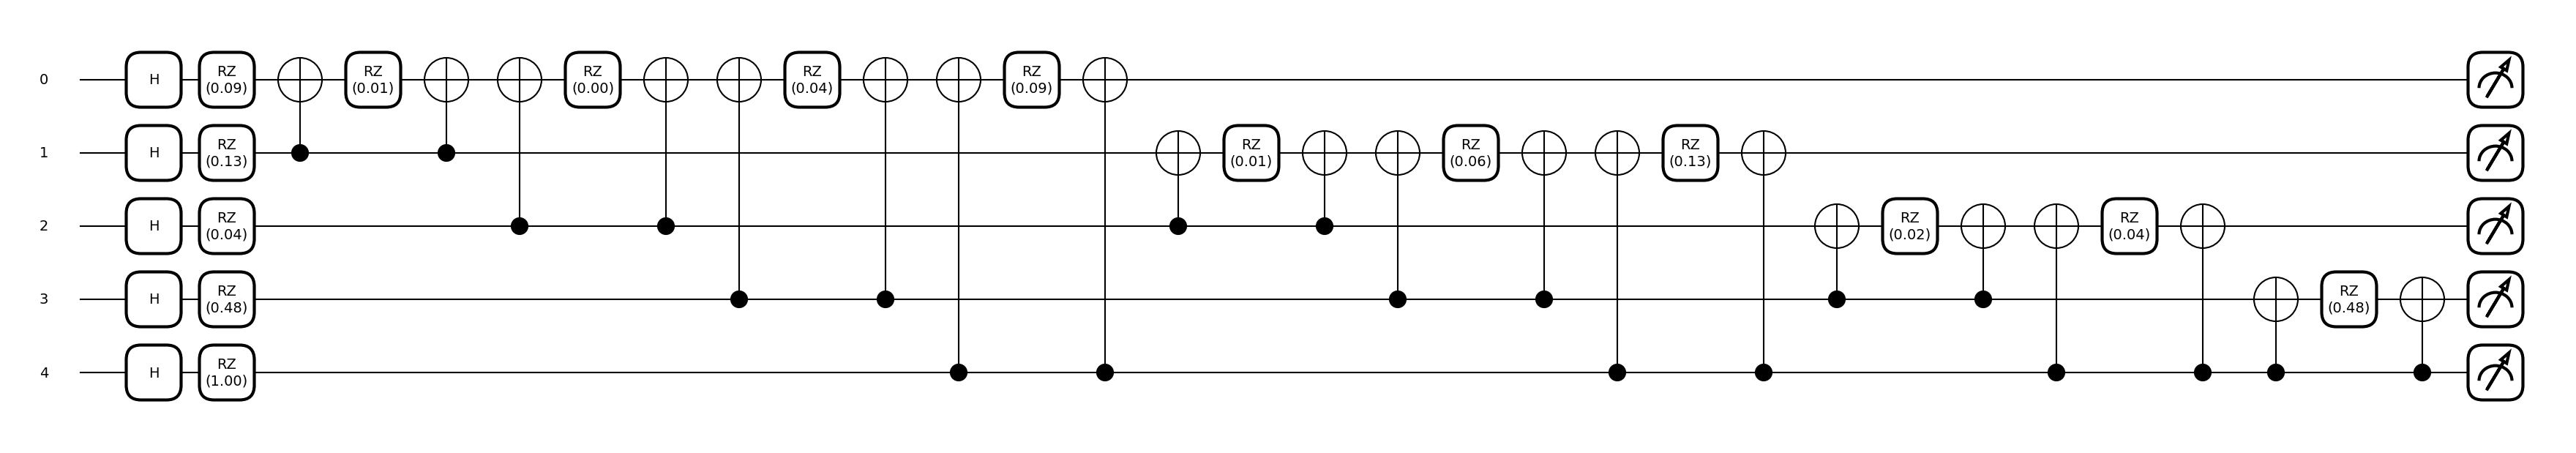

In [31]:
#or using pennylane's IQPEmbedding
from functools import partial

x = np.array([2,3,1,11,23])

n_qubits = len(x)

dev = qml.device('default.qubit', wires=n_qubits)

@partial(
    qml.transforms.decompose,
    gate_set={"RZ", "CNOT", "Hadamard"}
)
@qml.qnode(dev)
def iqp_encoding(x):
    max_abs_feature = np.max(np.abs(x))
    x_normalized = x/max_abs_feature

    qml.IQPEmbedding(x_normalized, wires=range(n_qubits), n_repeats=1)

    return qml.probs(wires=range(n_qubits))

qml.draw_mpl(iqp_encoding, decimals=2)(x)

iqp_encoding(x)
